<a href="https://colab.research.google.com/github/ioanasise/Skincare-Recommendation-System/blob/main/Skincare_Recommender_System_CL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install plotly
!pip install numpy
!pip install pyspark

     |████████████████████████████████| 281.4 MB 32 kB/s 
     |████████████████████████████████| 198 kB 61.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=fb349f3d4ef6a8c60a9849ff431a229955aef54e208fe180a3333835517a5cd6
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Formats values in pandas tables to 2dp
pd.set_option('display.float_format', lambda x: '%.2f' % x)

### A note from the Original Poster

> A note on data acquisition and feature engineering: I scraped Sephora.com using selenium webdriver and got two dataframes: user data and product data. They were merged together on unique user id, cleaned, which resulted in a big dataframe with the following columns: 'Username', 'Skin_Tone', 'Skin_Type', 'Eye_Color', 'Hair_Color','Rating_Stars', 'Review', 'Product', 'Brand', 'Price', 'Rating','Ingredients', 'Combination', 'Dry', 'Normal', 'Oily', 'Sensitive','Category', 'Product_Url', 'User_id', 'Product_id','Ingredients_Cleaned', 'Review_Cleaned', 'Good_Stuff', 'Ing_Tfidf'.

## Dataset Description
Based on the information givena description for the dataset was created.

* Username: username of the user who left a review for the specific product
* Skin_Tone: indicated skin color of the user
* Skin_Type: indicated skin type of the user
* Eye_Color: indicated eye color of the user
* Hair_Color: indicated hair color of the user
* Rating_Stars: selected rating that the user gave for the product on a scale of 1-5 stars
* Review: text of the review left by the user
* Product: name of the product
* Brand: brand name of the product
* Price: how much the product costs
* Rating: average rating of the product
* Ingredients: list of ingredients in the product
* Combination, Dry, Normal, Oily, Sensitive: One-hot encoded columns for skin type that the product targets
* Category: what type of product it's labeled as
* Product_Url: link to the product webpage
* User_id: unique id number of user
* Product_id: unique id number of product
* Ingredients_Cleaned: list of ingredients in the product, but cleaned and broken into list for each ingredient rather than a long block of text found in original Ingredients column
* Review_Cleaned: similar to Ingredients_Cleaned; cleaned text of the review from original Review column
* Good_Stuff: 1 or 0 for yes or no, indicator on Sephora's product pages for ingredients considered good/clean
* Ing_Tfidf: a more clean and simplified ingredient list of product, after considering how important specific words are to the set


# Part 1 - EDA, Preprocessing & Visualisation

1. Data Cleaning
2. Tokenization - splitting up items into smaller sections, removing certain characters and punctuation

3. Remove Stopwords - useless words((such as “the”, “a”, “an”, “in”)
4. Remove Punctuation
5. Lemmatisation - keeps the true meaning of the word (caring turns to care)

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/agorina91/final_project/master/Jupyter_Notebook_and_CSV/skindataall.csv', index_col = [0])

In [ ]:
# Exploratory data analysis
print(df.info())
print(f'Total Duplicate Rows: {df[df.duplicated(keep=False)].shape[0]}')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8649 entries, 0 to 8702
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Username             8649 non-null   object 
 1   Skin_Tone            8649 non-null   object 
 2   Skin_Type            8649 non-null   object 
 3   Eye_Color            8649 non-null   object 
 4   Hair_Color           8649 non-null   object 
 5   Rating_Stars         8649 non-null   int64  
 6   Review               8649 non-null   object 
 7   Product              8649 non-null   object 
 8   Brand                8649 non-null   object 
 9   Price                8649 non-null   int64  
 10  Rating               8649 non-null   float64
 11  Ingredients          8649 non-null   object 
 12  Combination          8649 non-null   int64  
 13  Dry                  8649 non-null   int64  
 14  Normal               8649 non-null   int64  
 15  Oily                 8649 non-null   i

In [ ]:
df.describe(include='all')

,Username,Skin_Tone,Skin_Type,Eye_Color,Hair_Color,Rating_Stars,Review,Product,Brand,Price,Rating,Ingredients,Combination,Dry,Normal,Oily,Sensitive,Category,Product_Url,User_id,Product_id,Ingredients_Cleaned,Review_Cleaned,Good_Stuff,Ing_Tfidf
count,8649,8649,8649,8649,8649,8649.00,8649,8649,8649,8649.00,8649.00,8649,8649.00,8649.00,8649.00,8649.00,8649.00,8649,8649,8649.00,8649.00,8649,8649,8649.00,8649
unique,6851,10,5,6,7,NaN,7496,315,60,NaN,NaN,299,NaN,NaN,NaN,NaN,NaN,4,315,NaN,NaN,299,7495,NaN,299
top,Eye,No data,Combination,Brown,Brunette,NaN,"Love all of the Murad products for acne, has b...",Beauty Elixir,CLINIQUE,NaN,NaN,No Info,NaN,NaN,NaN,NaN,NaN,Cleanser,https://www.sephora.com/product/beauty-elixir-...,NaN,NaN,['info'],"['love', 'murad', 'acne', 'ha', 'skin', 'care'...",NaN,info
freq,27,2102,3567,3529,3182,NaN,5,72,685,NaN,NaN,210,NaN,NaN,NaN,NaN,NaN,4117,72,NaN,NaN,210,5,NaN,210
mean,NaN,NaN,NaN,NaN,NaN,4.10,NaN,NaN,NaN,47.29,4.29,NaN,0.66,0.57,0.64,0.62,0.52,NaN,NaN,3429.43,155.09,NaN,NaN,0.62,NaN
std,NaN,NaN,NaN,NaN,NaN,1.36,NaN,NaN,NaN,35.77,0.47,NaN,0.47,0.50,0.48,0.49,0.50,NaN,NaN,1987.20,91.74,NaN,NaN,0.49,NaN
min,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN,NaN,4.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,NaN,NaN,0.00,0.00,NaN,NaN,0.00,NaN
25%,NaN,NaN,NaN,NaN,NaN,3.00,NaN,NaN,NaN,28.00,4.20,NaN,0.00,0.00,0.00,0.00,0.00,NaN,NaN,1696.00,73.00,NaN,NaN,0.00,NaN
50%,NaN,NaN,NaN,NaN,NaN,5.00,NaN,NaN,NaN,38.00,4.40,NaN,1.00,1.00,1.00,1.00,1.00,NaN,NaN,3437.00,155.00,NaN,NaN,1.00,NaN
75%,NaN,NaN,NaN,NaN,NaN,5.00,NaN,NaN,NaN,58.00,4.50,NaN,1.00,1.00,1.00,1.00,1.00,NaN,NaN,5158.00,236.00,NaN,NaN,1.00,NaN


In [ ]:
print("Product Categories")
print(*df['Category'].unique(), sep="\t")

Product Categories
Cleanser	Moisturizer	Face Mask	Treatment


In [ ]:
# distribution of continuous features
df[['Price', 'Rating_Stars', 'Rating']].describe()

,Price,Rating_Stars,Rating
count,8649.00,8649.00,8649.00
mean,47.29,4.10,4.29
std,35.77,1.36,0.47
min,4.00,1.00,0.00
25%,28.00,3.00,4.20
50%,38.00,5.00,4.40
75%,58.00,5.00,4.50
max,370.00,5.00,5.00


In [ ]:
# histograms of continuous features
fig = make_subplots(rows=1, cols=3, subplot_titles=("Price", "Rating Stars", "Rating"),horizontal_spacing = 0.1)


fig.add_trace(
    go.Histogram(
        x=df["Price"],
        name="Price",
        hovertemplate="<i>Price</i>: £%{y:.2f}"
        "<br><b>Product Quantity Range:</b>: %{x}<br>",
    ),
    row=1,
    col=1
)

fig.add_trace(
    go.Histogram(
        x=df["Rating_Stars"],
        name="Rating Stars",
        hovertemplate="<i>Rating Stars</i>: %{y}" "<br><b>Products:</b>: %{x}<br>",
    ),
    row=1,
    col=2,
)

fig.add_trace(
    go.Histogram(
        x=df["Rating"],
        name="Rating",
        hovertemplate="<i>Rating</i>: %{x}"
        "<br><b>Product Quantity Range:</b>: %{y}<br>",
    ),
    row=1,
    col=3,
)

# edit axis labels
fig['layout']['xaxis']['title']='Product Frequency'
fig['layout']['xaxis2']['title']='Rating Stars'
fig['layout']['xaxis3']['title']='Rating Score'
fig['layout']['yaxis']['title']='Price (£)'
fig['layout']['yaxis2']['title']='Rating Frequency'
fig['layout']['yaxis3']['title']='Rating Frequency'


fig.update_layout(title=dict(text="Rating Stuff", x = 0.5),
                  font=dict(
                    family="Century Gothic",
                    size=18
                ))
fig.show()


The previous check didn't detect any missing values even though there are some, but in a different format of string that says no data/no info

Text(0, 0.5, 'number of ratings')

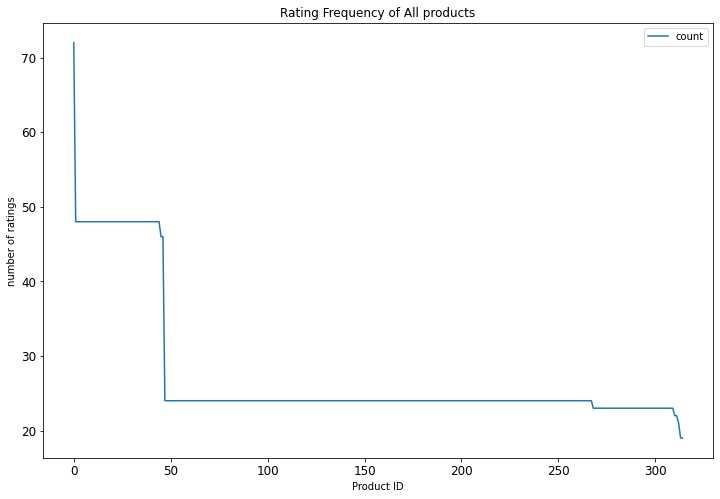

In [ ]:
# plot rating frequency of all movies
ax = df \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All products',
        fontsize=12
    )
ax.set_xlabel("Product ID")
ax.set_ylabel("number of ratings")


In [ ]:
print(df.value_counts('Skin_Tone', ascending=False))
print('\t')
print(df.value_counts('Skin_Type', ascending=False))
print('\t')
print(df.value_counts('Eye_Color', ascending=False))
print('\t')
print(df.value_counts('Hair_Color', ascending=False))
print('\t')
print(df.value_counts('Ingredients', ascending=False))

Skin_Tone
No data      2102
Light        1888
Fair         1453
Medium       1447
Olive         463
Tan           430
Porcelain     426
Deep          240
Dark          158
Ebony          42
dtype: int64
	
Skin_Type
Combination    3567
No data        2106
Dry            1223
Oily            961
Normal          792
dtype: int64
	
Eye_Color
Brown      3529
No data    2085
Blue       1263
Hazel       921
Green       803
Gray         48
dtype: int64
	
Hair_Color
Brunette    3182
No data     2092
Blonde      1461
Black       1459
Auburn       220
Red          187
Gray          48
dtype: int64
	
Ingredients
No Info                                                                                                                                                                                                                                                                                                                                                                                                 

In [ ]:

fig = make_subplots(rows = 2, cols = 2,
                    specs=[[{"type": "pie"}, {"type": "pie"}],
                           [{"type": "pie"}, {"type": "pie"}]])
print(df['Skin_Tone'].value_counts().index.tolist())
skin_color_palette = ["Red", "#F0DDD7", "#F3CFBB", "#c08e62", "#C68642", "#D2B48C", "#F0DDD7", "#9c7248", "#000000", "#7c501a"]
fig.add_trace(go.Pie(
     values= df['Skin_Tone'].value_counts(),
     labels = df['Skin_Tone'].value_counts().index.tolist(),
     name="Skin Tone", title = dict(text = "Skin Tone"),
     hovertemplate = "%{label} <br><b>Population</b>&nbsp; %{value:,}",
     hole = 0.4,
     marker_colors = skin_color_palette
     ), 
     row=1, col=1)


fig.add_trace(go.Pie(
     values=df['Skin_Type'].value_counts(),
     labels = df['Skin_Type'].value_counts().index.tolist(),
     name="Skin Type", title ="Skin Type",
     hovertemplate = "%{label} <br><b>Population</b>&nbsp; %{value:,}",
     hole = 0.4), 
     row=1, col=2)

fig.add_trace(go.Pie(
     values=df['Eye_Color'].value_counts(),
     labels =df['Eye_Color'].value_counts().index.tolist(),
     name="Eye Colour", title ="Eye Colour",
     hovertemplate = "%{label} <br><b>Population</b>&nbsp; %{value:,}",
     hole = 0.4 ), 
     row=2, col=1)

fig.add_trace(go.Pie(
     values=df['Hair_Color'].value_counts(),
     labels = df['Hair_Color'].value_counts().index.tolist(),
     name="Hair Colour", title ="Hair Colour",
     hovertemplate = "%{label} <br><b>Population</b>&nbsp; %{value:,}",
     hole = 0.4 ), 
     row=2, col=2)

fig.update_layout(width = 1000, height = 800, margin=dict(t=0, b=0, l=0, r=0), paper_bgcolor='rgb(160,160,160)',
    plot_bgcolor='rgb(160,160,160)')
fig.show()

['No data', 'Light', 'Fair', 'Medium', 'Olive', 'Tan', 'Porcelain', 'Deep', 'Dark', 'Ebony']


As we can see from this breakdown there is a significant amount of missing values

Skin_Tone
No data      2102

Skin_Type
No data        2106

Eye_Color
No data    2085

Hair_Color
No data     2092

The Ingredients column displays some missing data as well as some odd strings that are not ingredients:

Visit the Shiseido boutique
Visit the SEPHORA COLLECTION boutique 

## 1. Removing missing data

In [ ]:
# Basic EDA

def basic_eda(df, df_name):
    print(df_name.upper())
    print()
    print(f"Rows: {df.shape[0]} \t Columns: {df.shape[1]}")
    print()
    
    print(f"Total null rows: {df.isnull().sum().sum()}")
    print(f"Percentage null rows: {round(df.isnull().sum().sum() / df.shape[0] * 100, 2)}%")
    print()
    
    print(f"Total duplicate rows: {df[df.duplicated(keep=False)].shape[0]}")
    print(f"Percentage dupe rows: {round(df[df.duplicated(keep=False)].shape[0] / df.shape[0] * 100, 2)}%")
    print()
    
    print(df.dtypes)
    print("-----\n")

In [ ]:
# Drop columns
# Removing the missing data from those columns
skincare_data = df[df['Skin_Type'] != 'No data']
skincare_data = df[df['Eye_Color'] != 'No data']
# Replace missing value with nan, then drop the rows and reset the index.

skincare_data = skincare_data.replace(to_replace="No data", value=np.nan)
skincare_data.isna().values.any()
isNaValues= skincare_data.isnull()
NaN_rows = skincare_data[isNaValues.any(axis=1)]
print(NaN_rows)

skincare_data = skincare_data.dropna()
skincare_data = skincare_data.reset_index(drop=True)
print(f'Total null rows after cleaning : {skincare_data.isnull().sum().sum()}')

    

             Username  ...                                          Ing_Tfidf
400          Biggie88  ...  polysorbate, hamamelis, virginiana, witch, haz...
424          Biggie88  ...  polysorbate, hamamelis, virginiana, witch, haz...
853           epaz101  ...  cocamidopropyl, hydroxysultaine, juglans, regi...
877           epaz101  ...  cocamidopropyl, hydroxysultaine, juglans, regi...
1523     lakedweller2  ...  glycerin, vitis, vinifera, grape, seed, oil, c...
1980      Aurore2nuit  ...  c, alkyl, benzoate, carthamus, tinctorius, saf...
1989        Danni8427  ...  c, alkyl, benzoate, carthamus, tinctorius, saf...
2276      Jesscorners  ...  caprylic, capric, triglyceride, polyglyceryl, ...
2300      Jesscorners  ...  caprylic, capric, triglyceride, polyglyceryl, ...
2681       SamtheScot  ...  propanediol, glycerin, camellia, sinensis, lea...
2816       mekupmaven  ...                             visit, fresh, boutique
2822        NolanPaul  ...                             visit, fr

In [ ]:
fig = make_subplots(rows = 2, cols = 2,
                    specs=[[{"type": "pie"}, {"type": "pie"}],
                           [{"type": "pie"}, {"type": "pie"}]])
print(skincare_data['Skin_Tone'].value_counts().index.tolist())
skin_color_palette = ["#F0DDD7", "#F3CFBB", "#c08e62", "#C68642", "#D2B48C", "#F0DDD7", "#9c7248", "#000000", "#7c501a"]
fig.add_trace(go.Pie(
     values= skincare_data['Skin_Tone'].value_counts(),
     labels = skincare_data['Skin_Tone'].value_counts().index.tolist(),
     name="Skin Tone", title = dict(text = "Skin Tone"),
     hovertemplate = "%{label} <br><b>Population</b>&nbsp; %{value:,}<extra></extra>",
     hole = 0.4,
     marker_colors = skin_color_palette
     ), 
     row=1, col=1)


fig.add_trace(go.Pie(
     values=skincare_data['Skin_Type'].value_counts(),
     labels = skincare_data['Skin_Type'].value_counts().index.tolist(),
     name="Skin Type", title ="Skin Type",
     hovertemplate = "%{label} <br><b>Population</b>&nbsp; %{value:,}<extra></extra>",
     hole = 0.4), 
     row=1, col=2)

fig.add_trace(go.Pie(
     values=skincare_data['Eye_Color'].value_counts(),
     labels =skincare_data['Eye_Color'].value_counts().index.tolist(),
     name="Eye Colour", title ="Eye Colour",
     hovertemplate = "%{label} <br><b>Population</b>&nbsp; %{value:,}<extra></extra>",
     hole = 0.4 ), 
     row=2, col=1)

fig.add_trace(go.Pie(
     values=skincare_data['Hair_Color'].value_counts(),
     labels = skincare_data['Hair_Color'].value_counts().index.tolist(),
     name="Hair Colour", title ="Hair Colour",
     hovertemplate = "%{label} <br><b>Population</b>&nbsp; %{value:,}<extra></extra>",
     hole = 0.4 ), 
     row=2, col=2)

fig.update_layout(width = 1000, height = 800, margin=dict(t=0, b=0, l=0, r=0), paper_bgcolor='rgb(160,160,160)',
    plot_bgcolor='rgb(160,160,160)')
fig.show()

['Light', 'Fair', 'Medium', 'Olive', 'Tan', 'Porcelain', 'Deep', 'Dark', 'Ebony']


## 2. Ingredients NLP

In [ ]:
# tokenize ingredients
# The first step will be tokenizing the list of ingredients in Ingredients column. After splitting them into tokens, we'll make a binary bag of words.
# the separated parts are put in a list
import re 
def ing_delimiter(ingredients_row):
    delimiter = [',', ':', ';', '/', '\r', '\n', '\t', 'and', '-+', '_+', '[^\w\s]', 'ingredients', 'ingredient', ' no Info', 'visit', 'active/singredients']
    return re.split('|'.join(delimiter), ingredients_row.lower())

def tokenizer(x) -> list: 
    x = x.replace('(', '')
    x = x.replace(')', '')
    x = x.replace("\xa0", " ")
    x = x.replace(".", ",")
    x = x.replace(" & ", ", ")
    x = re.split(', ', x)
    return x

def water_parser(ingredients_list):
    water = ['water' if ('water' in ingredient and 'water-binding' not in ingredient) else ingredient for ingredient in ingredients_list]
    return water

In [ ]:
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Function to clean and tokenize text data:

def processing(data):
    # Everything in column to lowercase
    lower_data = data['Ingredients'].dropna(inplace=True)
    lower_data = data["Ingredients"].str.lower()
    # Remove punctuation chars
    processed = re.sub(r"[^a-zA-Z0-9]", " ", str(lower_data))
    processed = processed.strip('\n')
    # Tokenize
    tokenize = nltk.word_tokenize(processed)
    # Remove stopwords
    stop_words= ['ingredients', 'ingredient', 'other', 'no', 'info', 'please', ]
    stop_words = [x for x in tokenize if x not in stopwords.words(stop_words)]
    # Lemmatize, do not remove 'sls' and 'sles' ingredients 
    lemmantize = WordNetLemmatizer()
    lemmatized = [lemmantize.lemantize(word) if word not in ['sls', 'sles'] else word for word in stopwords]
    return lemmatized

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Ingredients NLP
# Ingredients droping missing data
# Water was also removed from each ingredients list because it appeared in almost all products and isn't important in defining a product's function.
cleaned_df = skincare_data[skincare_data['Ingredients'].str.contains("No Info") == False]
cleaned_df = cleaned_df[cleaned_df['Ingredients'].str.contains("Visit") == False]
cleaned_df = cleaned_df[cleaned_df['Ingredients'].str.contains("Please") == False]
print(type(cleaned_df))

# refactor this: take only ingredients column, NLP then append it back to the dataset.

<class 'pandas.core.frame.DataFrame'>


In [ ]:
# Declustered Water (+)/Aqua/Eau De-Structuree (+)  - convert this to just water

In [ ]:
# Drop Face Mask category as there is very little count and it would produce noise
skincare_data = skincare_data[skincare_data.Category != 'Face Mask']

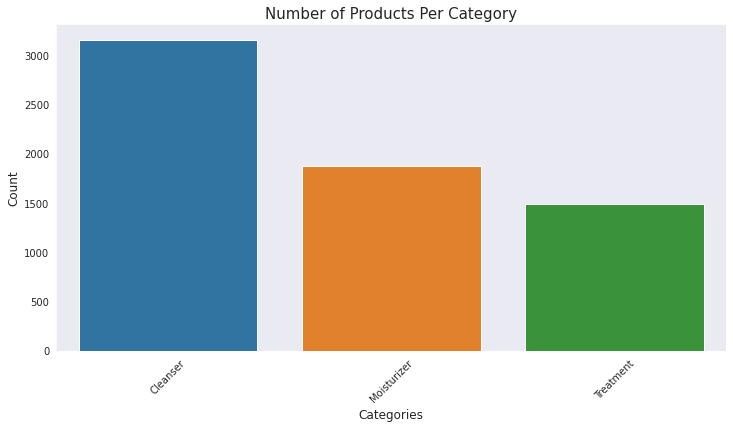

In [ ]:
# show distrubution of categories
plt.figure(figsize=(12,6))
sns.set_style('dark')

plot = sns.countplot(data=skincare_data, x='Category', order=skincare_data.Category.value_counts().index)
plt.setp(plot.get_xticklabels(), rotation=45)
plt.xlabel('Categories', size=12)
plt.ylabel('Count', size=12)
plt.title('Number of Products Per Category', size=15)
plt.show()

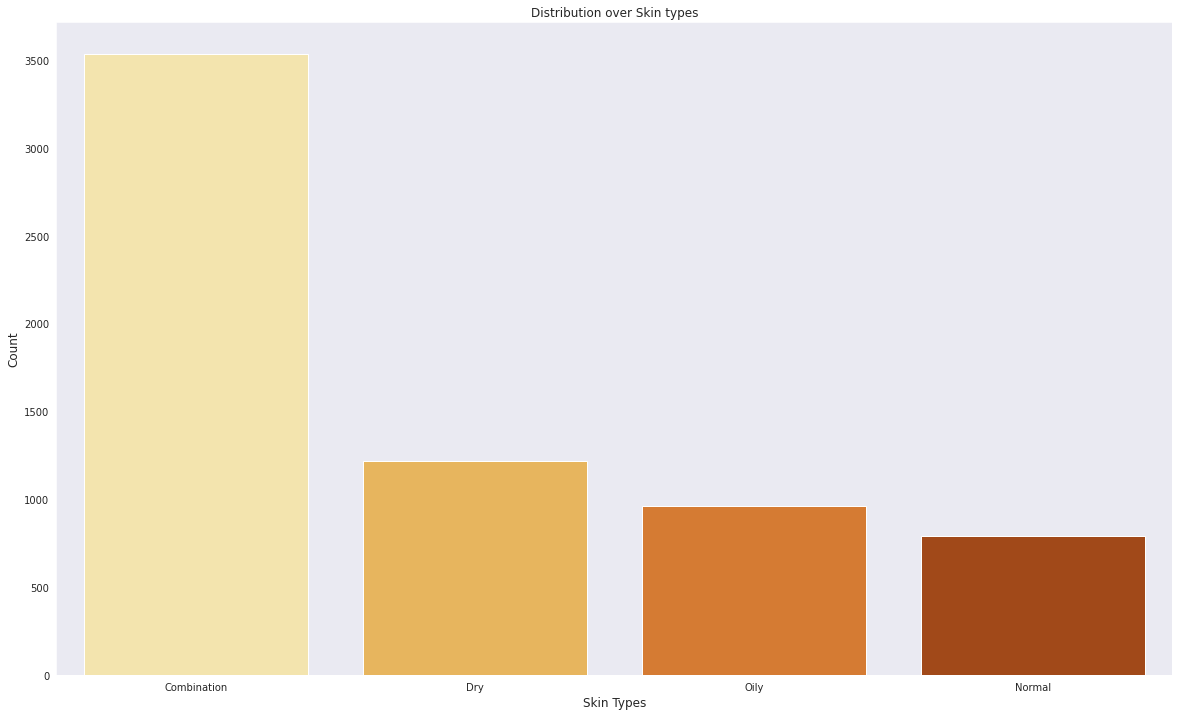

<bound method Series.count of 0       Combination
1       Combination
2           No data
3               Dry
4            Normal
           ...     
8698    Combination
8699    Combination
8700    Combination
8701        No data
8702        No data
Name: Skin_Type, Length: 8649, dtype: object>
<bound method Series.count of 0       Combination
1       Combination
2               Dry
3            Normal
4              Oily
           ...     
6526    Combination
6527           Oily
6528    Combination
6529    Combination
6530    Combination
Name: Skin_Type, Length: 5878, dtype: object>


In [ ]:
plt.figure(figsize=(20,12))
sns.set_style('dark')
plot = sns.countplot(data=skincare_data,
                     x='Skin_Type',
                     palette='YlOrBr',
                     order=skincare_data.Skin_Type.value_counts().index)
plt.xlabel('Skin Types', size=12)
plt.ylabel('Count', size=12)
plt.title('Distribution over Skin types')
plt.show()

print(df['Skin_Type'].count)
print(cleaned_df['Skin_Type'].count)

In [ ]:
# Create another df with new users to compare ot old users


In [ ]:
# There are two columns relating to ratings, visualising should show what the differences are between them


# fig = make_subplots(rows=1, cols=2,
#                     subplot_titles=('Rating Stars', 'Rating'))
# fig.add_trace(go.Bar(y=skincare_data['Rating_Stars'].value_counts(), 
#                      name='Rating Stars'), 
#               row=1, col=1)

# rating_bars = go.Bar(y=skincare_data.groupby('Rating')['Product_id'].count(), 
#                      name='Rating', 
#                      marker = dict(color = 'red'), 
#                      hovertemplate="<br>".join([
#                         "Rating: %{y}",
#                         '<extra></extra>'])
#                      )
# rating_bars.update_layout(xaxis = dict(
#                           tickmode = 'array',
#                           tickvals = [1, 3, 5, 7, 9, 11],
#                           ticktext = ['One', 'Three', 'Five', 'Seven', 'Nine', 'Eleven']))
# fig.add_trace(rating_bars, 
#               row=1, col=2)
# fig.update_layout(height=600, 
#                   width=800, 
#                   title_text="Side By Side Subplots"
# )
# fig.show()

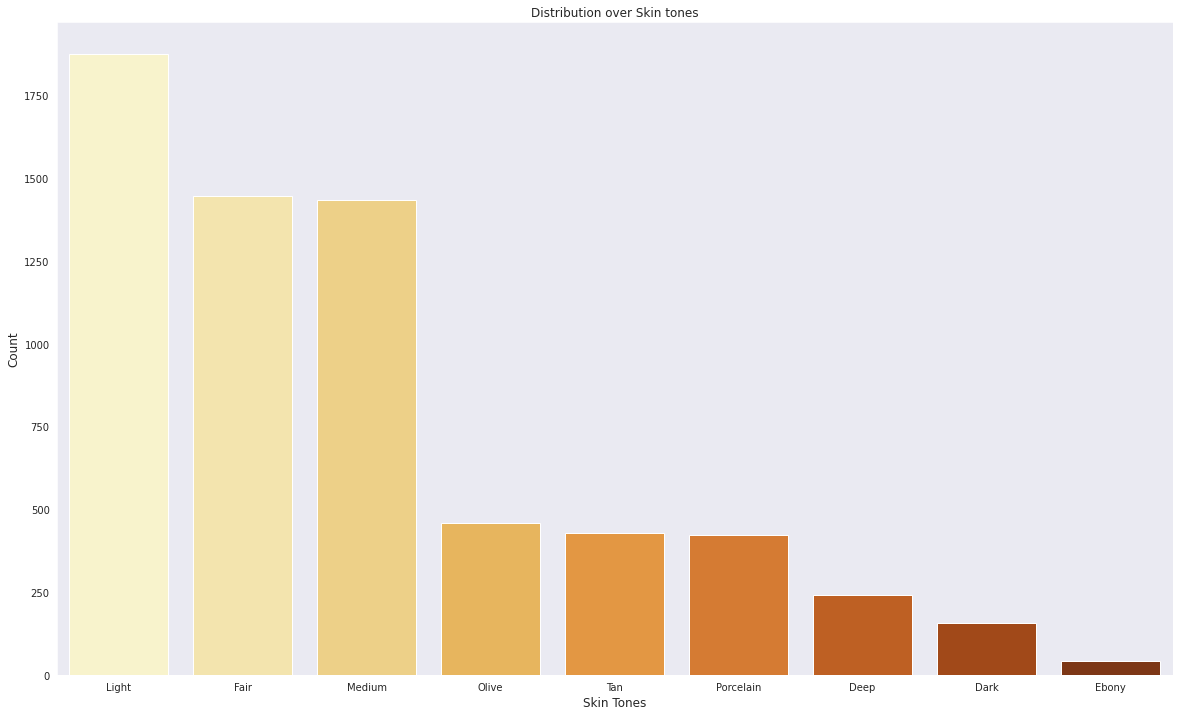

<bound method Series.count of 0        Medium
1        Medium
2       No data
3          Fair
4          Fair
         ...   
8698       Fair
8699      Light
8700       Dark
8701    No data
8702    No data
Name: Skin_Tone, Length: 8649, dtype: object>
<bound method Series.count of 0          Medium
1          Medium
2            Fair
3            Fair
4       Porcelain
          ...    
6526        Light
6527    Porcelain
6528         Fair
6529        Light
6530         Dark
Name: Skin_Tone, Length: 6510, dtype: object>


In [ ]:
# Plot skin tone
plt.figure(figsize=(20,12))
sns.set_style('dark')
plot = sns.countplot(data=skincare_data,
                     x='Skin_Tone',
                     palette='YlOrBr',
                     order=skincare_data.Skin_Tone.value_counts().index)
plt.xlabel('Skin Tones', size=12)
plt.ylabel('Count', size=12)
plt.title('Distribution over Skin tones')
plt.show()

print(df['Skin_Tone'].count)
print(skincare_data['Skin_Tone'].count)

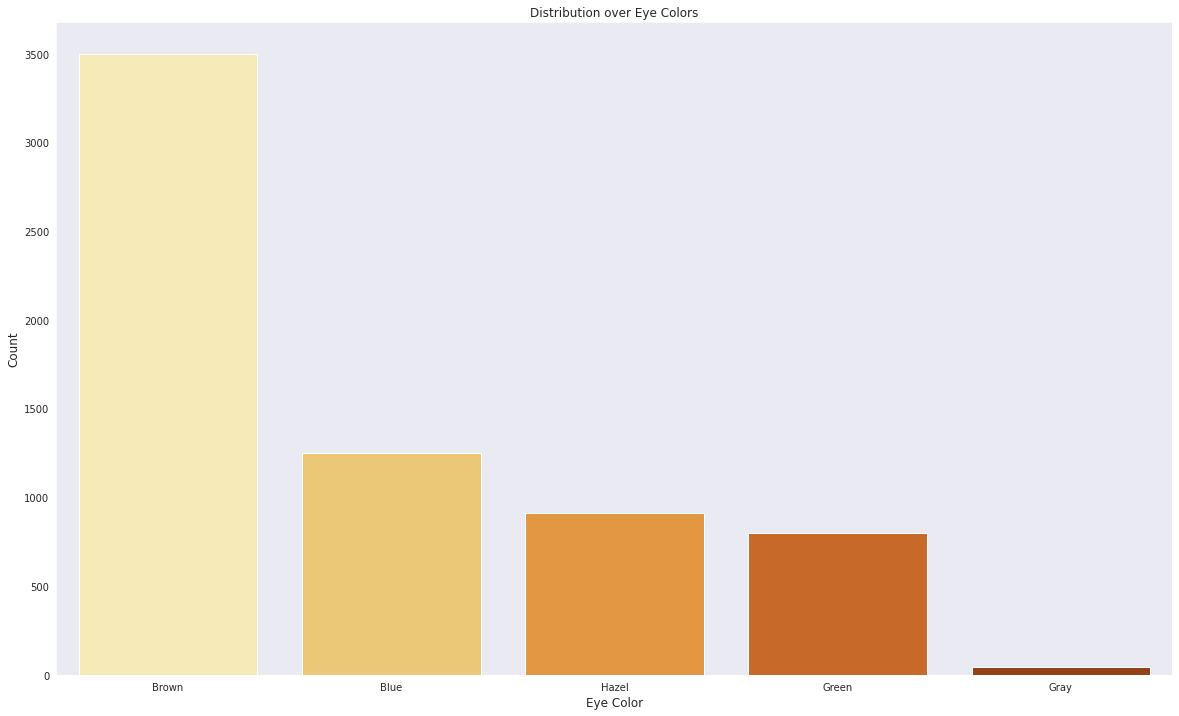

<bound method Series.count of 0         Brown
1         Brown
2       No data
3          Blue
4         Green
         ...   
8698      Hazel
8699       Blue
8700      Brown
8701    No data
8702    No data
Name: Eye_Color, Length: 8649, dtype: object>
<bound method Series.count of 0       Brown
1       Brown
2        Blue
3       Green
4        Blue
        ...  
6526    Green
6527     Blue
6528    Hazel
6529     Blue
6530    Brown
Name: Eye_Color, Length: 6510, dtype: object>


In [ ]:
# Plot eye colour
plt.figure(figsize=(20,12))
sns.set_style('dark')
plot = sns.countplot(data=skincare_data,
                     x='Eye_Color',
                     palette='YlOrBr',
                     order=skincare_data.Eye_Color.value_counts().index)
plt.xlabel('Eye Color', size=12)
plt.ylabel('Count', size=12)
plt.title('Distribution over Eye Colors')
plt.show()

print(df['Eye_Color'].count)
print(skincare_data['Eye_Color'].count)

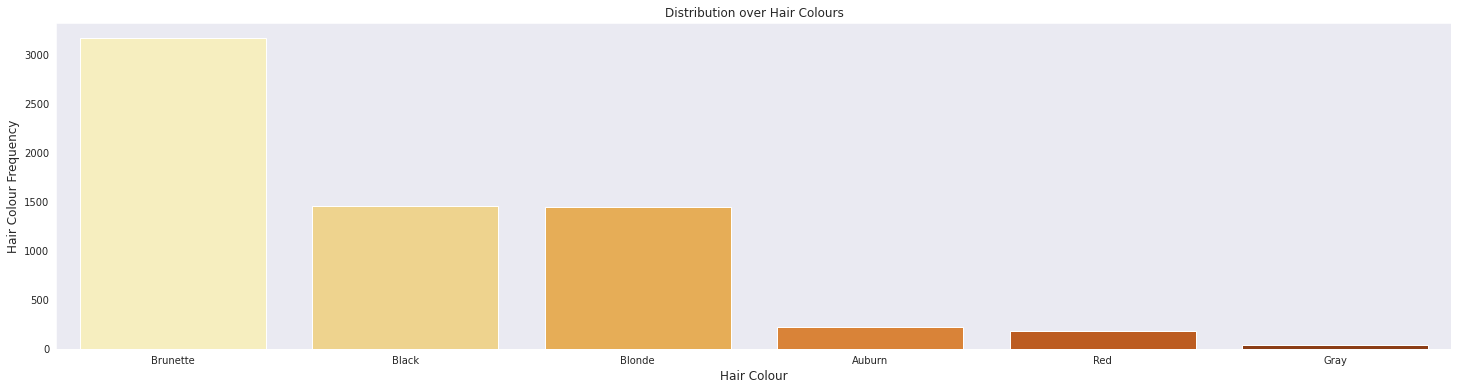

In [ ]:
# Plot hair colour
plt.figure(figsize=(25,6))
plot = sns.countplot(data=skincare_data,
                     x='Hair_Color',
                     palette='YlOrBr',
                     order=skincare_data.Hair_Color.value_counts().index)
plt.xlabel('Hair Colour', size=12)
plt.ylabel('Hair Colour Frequency', size=12)
plt.title('Distribution over Hair Colours')
plt.show()

# print(df['Hair_Color'].count)
# print(skincare_data['Hair_Color'].count)

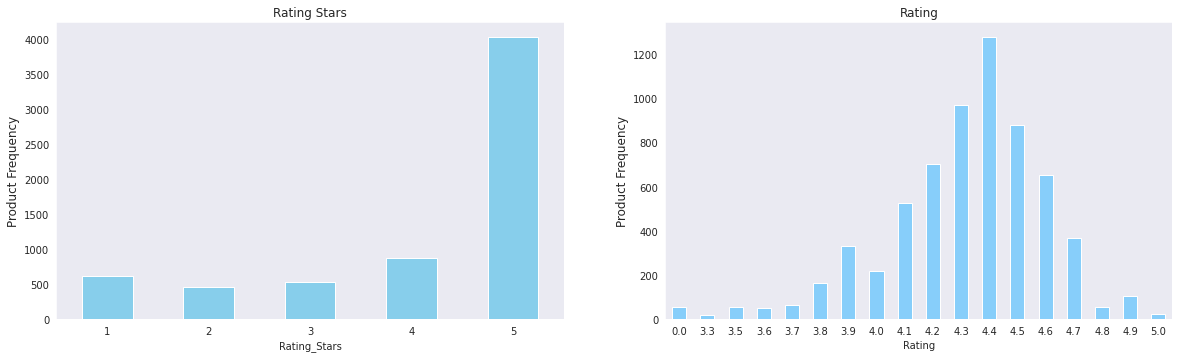

In [ ]:
# There are two columns relating to ratings, visualising should show what the differences are between them
plt.subplot(221)
plt.title('Rating Stars')
plt.ylabel('Product Frequency', size=12)
skincare_data.groupby('Rating_Stars')['Product_id'].count().plot.bar(color='skyblue', figsize=(20,12))
plt.xticks(rotation=0)

plt.subplot(222)
plt.title('Rating')
plt.ylabel('Product Frequency', size=12)
skincare_data.groupby('Rating')['Product_id'].count().plot.bar(color='lightskyblue', figsize=(20,12));
plt.xticks(rotation=0)
plt.show()

On the official Sephora website you can see that Rating_Star refers to individual product review and Rating refers to the Rating of the product.
When modelling we will be focused on user feature therefore individual product review is more relevant and thus will be using Rating_Star column to categorise the quality of the product.

# Part 2 - Modelling 

One of the reasons why it's so important to model a recommendation system is because on most websites such as Sephora you have different categories such as 'top sellers' 'recommended for you' but if you are a new member you wouldn't get a recommendation as such.
Therefore, one way to start recommending a more personalised selection for customers would be to have a way for them to filter the products they could see.
As such a user could use their skin type, moisturiser, skin colour etc.

In [ ]:
# Number of unique products
print(f"Unique Products : {skincare_data['Product'].nunique()}") 

Unique Products : 314


In [ ]:
import nltk # natural language processing
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Create function to assign each rating to a group

def select_rating(df, column, value1, value2, new_df):
    new_df = df[df[column].between(value1, value2)] #inclusive of the values
    print(f'The new DataFrame conists of the value and the value count:')
    print(new_df[column].value_counts()) # check results
    return new_df

#sample calling function:
#rating_t1 = select_rating(df_drop1,'Rating_Stars', 1.0, 5.0, 'rating_t1')

def select_col(df, column, value, new_df):
    new_df = df[df[column] == value] #inclusive of the values
    print(f'The new DataFrame conists of the value and the value count:')
    print(new_df[column].value_counts()) # check results
    return new_df

#sample calling function:
#column_1 = select_col(df_drop1,'Category', 'Cleanser', 'cleanser')

def join_str(new_str, series, name):
    new_str = " ".join(item for item in series)
    print(f'The String {name} has:')
    print('\n')
    print(new_str) # check results
    print('\n')
    return new_str

#sample calling function:
# new_r1 = join_str('new_r1', rating_t1.Review, 'reviews_rt1')

In [ ]:
!pip install surprise
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split, cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import knns
from surprise.model_selection import GridSearchCV
from surprise.similarities import cosine, msd, pearson
from surprise import accuracy

# Reading the given dataset points
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(skincare_data[['User_id', 'Product_id', 'Rating_Stars']], reader=reader)

# Split the dataset
trainset, testset = train_test_split(data, test_size=0.2)
print(f'Number of users: {trainset.n_users}')
print(f'Number of items: {trainset.n_items}')

     |████████████████████████████████| 11.8 MB 11.1 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630206 sha256=e8121997a5af7eac121eb7c992faab16253aa380faaccf2b303db9a0dec62271
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise
Number of users: 4369
Number of items: 314


Because we want to explore the item-to-item relationship we only used the users and items features as we want to keep them together.
Therefore, there isn't a usual split of X_train, Y_train. the dataset is split in 20% test set and 80% train. 
From the print statement above it can be observed there are more users then there are items, so we will calculate the similarity between the ones we have fewer of.


1. Item based collaborative filtering using KNN model

In [ ]:
# knn basic using cosine
similarity_cosine = {'name': 'cosine', 'user_based': False}
#train the model
basic_knn = knns.KNNBasic(sim_options =similarity_cosine)
basic_knn.fit(trainset)

#test model and see prediction performance
predictions = basic_knn.test(testset)
accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1917


1.191714751600857

In [ ]:
#knn basic using pearson
similarity_pearson = {'name': 'pearson', 'user_based': False}
basic_knn = knns.KNNBasic(sim_options =similarity_pearson)
basic_knn.fit(trainset)

#test predictions
predictions2= basic_knn.test(testset)
accuracy.rmse(predictions2)
# from surprise import evaluate
#algo = KNNBasic()
# evaluate(algo, data, measures=['RMSE', 'MAE'])

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1785


1.1785006941042848

From comparing the two scores it can be observed that using pearson to calculate similarity gives a slightly better performance compared to cosine, so it will be used in following itterations. 
The next step is to compare the performance of other KNN variations.

In [ ]:
# knn means using pearson
similarity_pearson = {'name': 'pearson', 'user_based': False}
knn_means = knns.KNNWithMeans(sim_options = similarity_pearson)
knn_means.fit(trainset)
predictions_means = knn_means.test(testset)
accuracy.rmse(predictions_means)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1772


1.1771787046015785

In [ ]:
# knn baseline using perason
knn_baseline = knns.KNNBaseline(sim_options= similarity_pearson)
knn_baseline.fit(trainset)
predictions_baseline= knn_baseline.test(testset)
accuracy.rmse(predictions_baseline)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1658


1.1657997145688128

In [ ]:
# cross-validation with KNN baseline

cv_knn_baseline = cross_validate(knn_baseline, data)

for i in enumerate(cv_knn_baseline.items()):
        print(f'folds: {i}')

print("Cross Validation : %.3f" % (np.mean(cv_knn_baseline['test_rmse'])))

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
folds: (0, ('test_rmse', array([1.22677942, 1.1854873 , 1.21826177, 1.16490524, 1.19593039])))
folds: (1, ('test_mae', array([0.87457544, 0.84982971, 0.87548288, 0.85577177, 0.86911664])))
folds: (2, ('fit_time', (0.02771472930908203, 0.02398371696472168, 0.023595809936523438, 0.024190425872802734, 0.025902986526489258)))
folds: (3, ('test_time', (0.011201143264770508, 0.010628461837768555, 0.010988950729370117, 0.010990142822265625, 0.010857105255126953))

Using cross validation on the baseline method resulted in the lowest RMSE 1.14 using pearson correlation. After cross-validation the model performs with RMSE of 1.2 which is better than other KNN models.
There are some downsides of using memory-based methods which will be explored in the report therefore, I will try to use some model based methods.

2. Matrix Factorisation using SVD and ALS

In [ ]:
#initialising algorithm
svd = SVD()
svd.fit(trainset)
#predict and calculate RMSE
predictions= svd.test(testset)
accuracy.rmse(predictions)

RMSE: 1.2408


1.2407914307518038

In [ ]:
from surprise.prediction_algorithms import SlopeOne
from surprise.prediction_algorithms import NMF
from surprise.prediction_algorithms import CoClustering
scores = []
algorithms = [SVD(), SlopeOne(), NMF(), CoClustering()]
for algorithm in algorithms:
    results = cross_validate(algorithm, data, measures=['rmse'], cv=5)

    #store result and append to a df
    temp= pd.DataFrame.from_dict(results).mean(axis=0)
    temp = temp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    scores.append(temp)
pd.DataFrame(scores).set_index('Algorithm').sort_values(by='test_rmse',ascending=True)

,test_rmse,fit_time,test_time
Algorithm,,,
SlopeOne,1.25,0.05,0.01
NMF,1.25,0.80,0.01
CoClustering,1.25,0.58,0.01
SVD,1.26,0.33,0.03


Before proceeding with Matrix factorisation I decided to test some other algorithms to see how they perform. As it can be seen from the dataframe NMF performed well with 1.23 RMSE but took longer than SVD which was behind by a small amount. So moving forward I decided to do some hyper-parameter tuning for the CVD algorithm.

In [ ]:
param_grid = {
        'n_factors':[50,100,150],
        'n_epochs':[20,30],  
        'lr_all':[0.005,0.01],
        'reg_all':[0.02,0.1]
    }

grids_svd = GridSearchCV(SVD, param_grid=param_grid, n_jobs =-1, measures=['rmse'])
grids_svd.fit(data)

print(grids_svd.best_params['rmse'])

{'n_factors': 150, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.02}


In [ ]:
svd = SVD(n_factors= 150, n_epochs= 30, lr_all= 0.01, reg_all= 0.02)
svd.fit(trainset)
#predict and calculate RMSE
predictions= svd.test(testset)
accuracy.rmse(predictions)

RMSE: 1.1775


1.1774928542318084

Before the grid search method to find the best parameters, SCD had an RMSE of 1.25. Consequently, after parameter tuning the performance has increased slightly with the RMSE of 1.17. Comparatively KNN baseline had a RMSE of 1.2 which is very close to the results I got here.


## Alternating Least Squares
 - ALS work well for solving scalability and sparseness of the Ratings data, it's simple and scales well to large datasets.

In [ ]:
# Creating a spark environment to use Alternating Least Square Matrix Factorization
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession
appName= 'Skincare Recommender'
spark = SparkSession.builder.appName(appName).config('spark.driver.host', 'localhost').getOrCreate()

In [ ]:
#load dataset into spark
spark_data=spark.createDataFrame(df) 
# spark_data.printSchema()
spark_data.show()

+---------------+---------+-----------+---------+----------+------------+--------------------+--------------------+-------------------+-----+------+--------------------+-----------+---+------+----+---------+--------+--------------------+-------+----------+--------------------+--------------------+----------+--------------------+
|       Username|Skin_Tone|  Skin_Type|Eye_Color|Hair_Color|Rating_Stars|              Review|             Product|              Brand|Price|Rating|         Ingredients|Combination|Dry|Normal|Oily|Sensitive|Category|         Product_Url|User_id|Product_id| Ingredients_Cleaned|      Review_Cleaned|Good_Stuff|           Ing_Tfidf|
+---------------+---------+-----------+---------+----------+------------+--------------------+--------------------+-------------------+-----+------+--------------------+-----------+---+------+----+---------+--------+--------------------+-------+----------+--------------------+--------------------+----------+--------------------+
|      

In [ ]:
products_columns = ['Product', 'Brand', 'Product_id', 'Rating_Stars']
products = spark_data.select(products_columns).drop_duplicates()

In [ ]:
#select features to use
spark_data.select('User_id', 'Product_id', 'Rating_Stars')

DataFrame[User_id: bigint, Product_id: bigint, Rating_Stars: bigint]

In [ ]:
# Transform the columns to be the right type, as ALS only accepts integers
from pyspark.sql.types import ShortType, ByteType

spark_data = spark_data.withColumn('User_id', spark_data['User_id'].cast(ShortType()))
spark_data = spark_data.withColumn('Product_id', spark_data['Product_id'].cast(ShortType()))
spark_data = spark_data.withColumn('Rating_Stars', spark_data['Rating_Stars'].cast(ByteType()))
# Fill any NaNs with the value
spark_data = spark_data.select(['User_id', 'Product_id', 'Rating_Stars']).fillna(0)

In [ ]:
# Import the required packages to model
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
# credit goes towards data scientist Snehal Nair whos implementation was used as a guide
# Create train and test set
(train, test)=spark_data.randomSplit([0.8, 0.2])
# Initialise ALS and fit train set
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als=ALS(userCol='User_id',
        itemCol='Product_id',
        ratingCol='Rating_Stars',
        nonnegative=True,
        coldStartStrategy='drop'
)

# Setup parameter grid
params = ParamGridBuilder().addGrid(als.regParam, [.01, .05, .1, .15])\
            .addGrid(als.rank, [2, 25, 50, 100]).build()

reg_evaluator = RegressionEvaluator(metricName='rmse',
                                labelCol='Rating_Stars',
                                predictionCol='prediction')

# Initiate cross validation
# Allow for more than one model to be trained and evaluated at the same time and make better use of cluster resources
cv = CrossValidator(estimator=als, estimatorParamMaps=params, evaluator=reg_evaluator, parallelism=3)
model = cv.fit(train)
best_model = model.bestModel
# The easiest way to return the best parameters
print(f"Rank = {best_model._java_obj.parent().getRank()}")
print(f"RegParam = {best_model._java_obj.parent().getRegParam()}")

# View the predictions
test_predictions = best_model.transform(test)
RMSE = reg_evaluator.evaluate(test_predictions)
print(RMSE)



Rank = 100
RegParam = 0.05
1.2134514426024339


In [ ]:
# fit ALS with new parameters
als_new = ALS(maxIter=5,
        rank= 100,
        regParam=0.05,
        userCol='User_id',
        itemCol='Product_id',
        ratingCol='Rating_Stars',
        nonnegative=True,
        implicitPrefs=False,
        coldStartStrategy='drop')
#fit ALS to train set
new_model = als_new.fit(train)
predictions= new_model.transform(test)
evaluator = RegressionEvaluator(metricName='rmse',
                                labelCol='Rating_Stars',
                                predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
rmse
predictions.show()

+-------+----------+------------+----------+
|User_id|Product_id|Rating_Stars|prediction|
+-------+----------+------------+----------+
|   3488|       257|           5|  4.991057|
|   2231|       182|           5|  4.989299|
|   2392|       257|           5| 4.9905066|
|   6154|       108|           5| 1.4444566|
|   1653|        36|           4| 3.9768755|
|   2797|       257|           5| 4.9831805|
|   4796|        52|           5|  4.991088|
|   2606|       210|           1| 0.9983669|
|   2739|       257|           5| 4.9917912|
|    126|       257|           5| 4.9917912|
|   3026|       172|           5| 4.9910436|
|   3538|        55|           4| 0.7814661|
|   1489|       113|           5| 4.9915314|
|   2386|        81|           5| 4.9910846|
|   3582|       255|           4|  2.748846|
|   3582|       255|           4|  2.748846|
|   1574|       249|           3| 2.9939134|
|    667|       310|           2| 1.9967066|
|   3595|        57|           5| 4.9907455|
|   1493| 

In [ ]:
from pyspark.sql.functions import col, explode, lit
rec_all = new_model.recommendForAllUsers(10)
# displays 10 recommendations
rec_all.limit(10).show()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



+-------+--------------------+
|User_id|     recommendations|
+-------+--------------------+
|     12|[{31, 4.9909415},...|
|     13|[{156, 4.9886518}...|
|     22|[{243, 4.9902725}...|
|     26|[{211, 1.9958627}...|
|     27|[{190, 1.9960902}...|
|     28|[{28, 4.990902}, ...|
|     44|[{114, 4.9917984}...|
|     47|[{256, 3.9922564}...|
|     52|[{289, 4.9904594}...|
|     53|[{19, 4.9925437},...|
+-------+--------------------+



In [ ]:
# Displays 10 recommendations with the 'recommendations' column split up
rec_all = rec_all.withColumn('rec_exp', explode('recommendations')).select('User_id', col('rec_exp.Product_id'), col('rec_exp.rating'))
rec_all.limit(10).show()

+-------+----------+---------+
|User_id|Product_id|   rating|
+-------+----------+---------+
|     12|        31|4.9909415|
|     12|       132| 3.812664|
|     12|       111|3.7200198|
|     12|       297|3.6222563|
|     12|       261|  3.60571|
|     12|       294|  3.58912|
|     12|       266|3.5846827|
|     12|        51|3.5428479|
|     12|       265|3.4976828|
|     12|       109|3.4882717|
+-------+----------+---------+



In [ ]:
# username = input("Enter username: ")
# category = input('Enter skincare category: ')
# skinType = input('Enter skin type: ')
# test = rec_all.filter(f'User_id =={username}').withColumn('Category'==category , 'Skin_Type'== skinType)
user = input('Enter user id: ')
# join products and user_feature df's on product_id column and order by rating *highest to lowest)
rec_all.join(products, on='Product_id', how= 'inner').filter(f"User_id == {user}").orderBy('rating', ascending= False).show(truncate= False)


Enter user id: 23
+----------+-------+---------+-----------------------------------+------------------+------------+
|Product_id|User_id|rating   |Product                            |Brand             |Rating_Stars|
+----------+-------+---------+-----------------------------------+------------------+------------+
|204       |23     |4.9903927|Problem Solution Toner             |BELIF             |2           |
|204       |23     |4.9903927|Problem Solution Toner             |BELIF             |3           |
|204       |23     |4.9903927|Problem Solution Toner             |BELIF             |4           |
|204       |23     |4.9903927|Problem Solution Toner             |BELIF             |1           |
|204       |23     |4.9903927|Problem Solution Toner             |BELIF             |5           |
|285       |23     |2.8724337|U.F.O. Ultra-Clarifying Face Oil   |SUNDAY RILEY      |1           |
|285       |23     |2.8724337|U.F.O. Ultra-Clarifying Face Oil   |SUNDAY RILEY      |3     

In [ ]:
# recommend things the users hasn't rated yet
user = int(input('Enter user id: '))

# Skincare not rated by the selected user
products_to_be_rated = (predictions
                      .filter(f"User_id != {user}")
                      .select("Product_id").distinct()
                    .withColumn("User_id", lit(user))
)
# Predictions on skincare products they haven't tried yet
user_product_predic = new_model.transform(products_to_be_rated)

# Movie recommendations for selected user 
((user_product_predic
.dropna()
.orderBy("prediction",ascending = False)
.limit(10)
.join(products,["Product_id"])
.select("User_id","Product_id","Product",'Brand','Rating_Stars',col("prediction").alias("rating"))
.orderBy("rating",ascending = False)
).drop_duplicates()).show(truncate=False)


Enter user id: 20
+-------+----------+-------------------------------------------+------------------+------------+---------+
|User_id|Product_id|Product                                    |Brand             |Rating_Stars|rating   |
+-------+----------+-------------------------------------------+------------------+------------+---------+
|20     |57        |Checks and Balances™ Frothy Face Wash      |ORIGINS           |3           |2.950057 |
|20     |272       |The True Cream Moisturizing Bomb           |BELIF             |3           |3.112266 |
|20     |270       |The Treatment Lotion                       |LA MER            |5           |2.6263113|
|20     |55        |Ceramidin™ Cream                           |DR. JART+         |3           |3.0235791|
|20     |297       |Vine[activ] Overnight Detox Oil            |CAUDALIE          |4           |3.2648578|
|20     |36        |Bi-Facil Double-Action Eye Makeup Remover  |LANCÔME           |4           |3.0610688|
|20     |272       

# 4. Recommendation system

In [ ]:
# Recommend products based on users features
def rec_by_user_features(skin_type, category_type):
    rec_df= skincare_data[(skincare_data['Skin_Type']==skin_type) & (skincare_data['Category'] ==category_type)]
    product_rec = rec_df[['Rating', 'Product', 'Brand']]
    product_rec = product_rec.sort_values('Rating', ascending=False).drop_duplicates().head()
    # Return the best rated items for the features selected
    return product_rec

rec_by_user_features('Oily', 'Cleanser')

,Rating,Product,Brand
3526,5.00,Epidermal Re-Texturizing Micro-Dermabrasion,KIEHL'S SINCE 1851
3898,4.90,Exfoilating Wipes - Papaya - Glow,SEPHORA COLLECTION
4786,4.90,Fresh Pressed Renewing Powder Cleanser with Pu...,CLINIQUE
4488,4.90,Multi-Miracle Glow Cleansing Balm,CHARLOTTE TILBURY
433,4.90,Facial Cotton,SHISEIDO


This is a very basic way of predicting what a customer would like so to further recommend products that are more personalised towards customer preferences, I will use KNN Baseline model to make these recommendations.

In [ ]:
user_features = ['User_id', 'Skin_Tone', 'Skin_Type', 'Eye_Color', 'Hair_Color', 
                   'Product_id', 'Product', 'Brand', 'Category', 'Rating_Stars']
user_set = skincare_data[user_features].copy()

physical_features = ['Skin_Type', 'Skin_Tone', 'Eye_Color', 'Hair_Color']
user_set['combined_features'] = user_set['Skin_Type'] + ", " +  user_set['Skin_Tone'] + ", " +  user_set['Eye_Color'] + ", " +  user_set['Hair_Color']
user_set.head()

,User_id,Skin_Tone,Skin_Type,Eye_Color,Hair_Color,Product_id,Product,Brand,Category,Rating_Stars,combined_features
0,3420,Medium,Combination,Brown,Brunette,157,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,Cleanser,5,"Combination, Medium, Brown, Brunette"
1,2483,Medium,Combination,Brown,Red,157,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,Cleanser,1,"Combination, Medium, Brown, Red"
2,4497,Fair,Dry,Blue,Blonde,157,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,Cleanser,5,"Dry, Fair, Blue, Blonde"
3,5017,Fair,Normal,Green,Blonde,157,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,Cleanser,5,"Normal, Fair, Green, Blonde"
4,3776,Porcelain,Oily,Blue,Brunette,157,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,Cleanser,1,"Oily, Porcelain, Blue, Brunette"


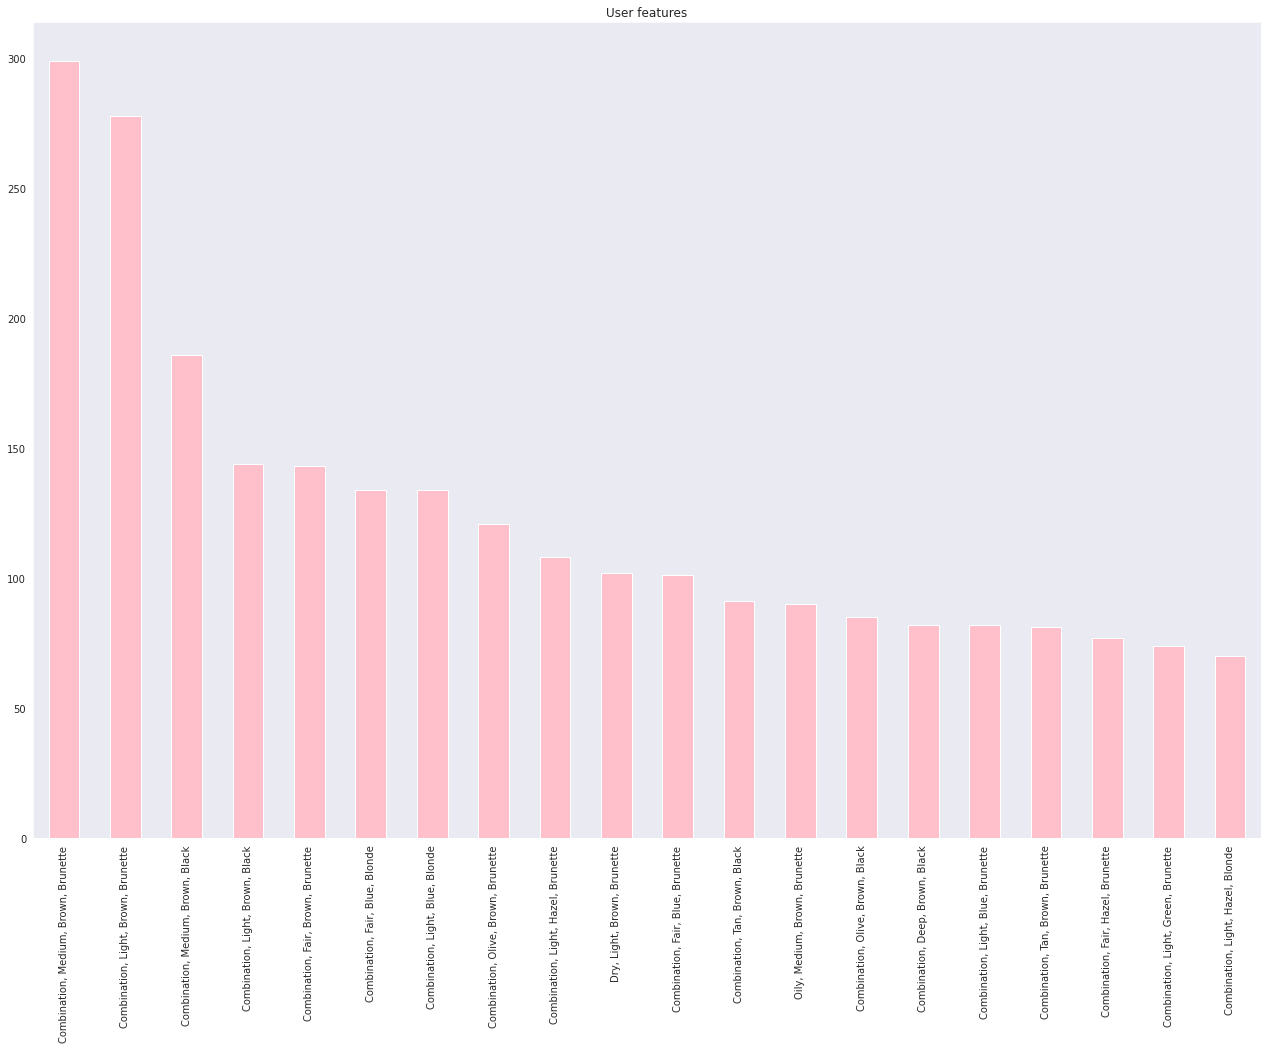

In [ ]:
plt.figure(figsize=(22,15))
cvalues = user_set['combined_features'].value_counts().head(20)
x_axis= cvalues.plot(kind = 'bar', color='pink', title='User features')

plt.xticks(rotation=90)
plt.show(x_axis)

The plot above shows a dominance whithin people with combination skin and it is not surprising to see as the majority of people will deal with skin type/texture changes throughout their lifes, more typically being oily or combination during their 20-30s and moving towards a dry skin type later in life as certain hormones change.

In [ ]:
matrix = user_set.pivot_table(index='Product',columns='combined_features', values='Rating_Stars')
matrix.head()

combined_features,"Combination, Dark, Brown, Auburn","Combination, Dark, Brown, Black","Combination, Dark, Brown, Blonde","Combination, Dark, Brown, Brunette","Combination, Deep, Brown, Auburn","Combination, Deep, Brown, Black","Combination, Deep, Brown, Blonde","Combination, Deep, Brown, Brunette","Combination, Deep, Green, Auburn","Combination, Deep, Hazel, Black","Combination, Deep, Hazel, Brunette","Combination, Ebony, Blue, Gray","Combination, Ebony, Brown, Auburn","Combination, Ebony, Brown, Black","Combination, Ebony, Brown, Brunette","Combination, Fair, Blue, Auburn","Combination, Fair, Blue, Black","Combination, Fair, Blue, Blonde","Combination, Fair, Blue, Brunette","Combination, Fair, Blue, Gray","Combination, Fair, Blue, Red","Combination, Fair, Brown, Auburn","Combination, Fair, Brown, Black","Combination, Fair, Brown, Blonde","Combination, Fair, Brown, Brunette","Combination, Fair, Brown, Gray","Combination, Fair, Brown, Red","Combination, Fair, Gray, Black","Combination, Fair, Gray, Blonde","Combination, Fair, Gray, Brunette","Combination, Fair, Gray, Red","Combination, Fair, Green, Auburn","Combination, Fair, Green, Black","Combination, Fair, Green, Blonde","Combination, Fair, Green, Brunette","Combination, Fair, Green, Gray","Combination, Fair, Green, Red","Combination, Fair, Hazel, Auburn","Combination, Fair, Hazel, Black","Combination, Fair, Hazel, Blonde",...,"Oily, Medium, Hazel, Auburn","Oily, Medium, Hazel, Black","Oily, Medium, Hazel, Blonde","Oily, Medium, Hazel, Brunette","Oily, Medium, Hazel, Red","Oily, Olive, Blue, Blonde","Oily, Olive, Blue, Brunette","Oily, Olive, Brown, Black","Oily, Olive, Brown, Blonde","Oily, Olive, Brown, Brunette","Oily, Olive, Gray, Black","Oily, Olive, Gray, Brunette","Oily, Olive, Green, Brunette","Oily, Olive, Hazel, Black","Oily, Olive, Hazel, Blonde","Oily, Olive, Hazel, Brunette","Oily, Porcelain, Blue, Auburn","Oily, Porcelain, Blue, Blonde","Oily, Porcelain, Blue, Brunette","Oily, Porcelain, Brown, Auburn","Oily, Porcelain, Brown, Black","Oily, Porcelain, Brown, Blonde","Oily, Porcelain, Brown, Brunette","Oily, Porcelain, Brown, Red","Oily, Porcelain, Green, Black","Oily, Porcelain, Green, Blonde","Oily, Porcelain, Green, Brunette","Oily, Porcelain, Green, Red","Oily, Porcelain, Hazel, Auburn","Oily, Porcelain, Hazel, Blonde","Oily, Porcelain, Hazel, Brunette","Oily, Porcelain, Hazel, Red","Oily, Tan, Blue, Blonde","Oily, Tan, Blue, Brunette","Oily, Tan, Brown, Black","Oily, Tan, Brown, Blonde","Oily, Tan, Brown, Brunette","Oily, Tan, Green, Blonde","Oily, Tan, Green, Brunette","Oily, Tan, Hazel, Blonde"
Product,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
+Retinol Vita C Power Serum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100 percent Pure Argan Oil,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100 percent Pure Argan Oil Light,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.50,NaN,NaN,NaN,NaN,NaN,NaN,5.00,NaN,NaN,NaN,NaN,3.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3 Muslin Cloths,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.00,NaN,NaN,NaN,NaN,NaN,4.00,5.00,NaN,NaN,5.00,NaN,NaN,NaN,NaN,NaN,NaN,5.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

# 1. Correlation model

In [ ]:
#Correlation model using matrix factorisation
def user_rec_bline_model(combined_features, recommendations=5, data=user_set):
    
    similarity = matrix.corrwith(matrix[combined_features])
    correlation = pd.DataFrame(similarity, columns=['correlation'])
    correlation.dropna(inplace=True)
    skincare_copy = data.copy()

    corr_features = pd.merge(
        left=correlation, right=skincare_copy, on='combined_features')[['Product', 'Category', 'combined_features', 'correlation', 'Rating_Stars']].drop_duplicates().reset_index(drop=True)
    result = corr_features[corr_features['correlation']==1.0].sort_values(by=['Rating_Stars', 'Product'], ascending=[False,True])
    return result.head(recommendations)
#testing the recommendations
user_rec_bline_model('Dry, Medium, Brown, Brunette')

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2683: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2542: RuntimeWarning:

divide by zero encountered in true_divide



,Product,Category,combined_features,correlation,Rating_Stars
2867,Aqua Bomb Sleeping Mask,Moisturizer,"Dry, Medium, Brown, Brunette",1.00,5
2885,Benefiance WrinkleResist24 Balancing Softener ...,Moisturizer,"Dry, Medium, Brown, Brunette",1.00,5
2894,Bio Retinoid Anti-Wrinkle Concentrate Oil,Treatment,"Dry, Medium, Brown, Brunette",1.00,5
2859,Black Tea Corset Cream Firming Moisturizer,Moisturizer,"Dry, Medium, Brown, Brunette",1.00,5
2879,Cleansing Spa Water Cloths,Cleanser,"Dry, Medium, Brown, Brunette",1.00,5


In [ ]:
# https://github.com/toscatle/skincare_recommender/blob/main/skincare_recommender_notebook.ipynb
def skincare_rec(num, product_df, category=None, skin_type=None):
    raw_userid = input('Enter ID: ')
    rating_list = []
    #filter df based on skin type/category and get new ratings
    while num > 0:
        if skin_type:
            product_df = product_df[product_df[skin_type] == 1]
        else:
            product_df = product_df
        if category:
            product_df = product_df[product_df['Category'] == category]
            product = product_df.sample(1)
        else:
            product = product_df.sample(1)
        print(product[['Product', 'Brand', 'Price', 'Product_Url']])
        rating = input(
            'How do you rate this product on a scale of 1-5, press n if you have not used this before:\n'
        )
        if rating == 'n':
            continue
        else:
            rating_one_product = {
                'User_id': raw_userid,
                'Product_id': product['Product_id'].values[0],
                'Rating_Stars': rating
            }
            rating_list.append(rating_one_product)
            num -= 1

    #add the new ratings to the original df
    new_ratings_df = product_df[['User_id', 'Product_id',
                                 'Rating_Stars']].append(rating_list,
                                                         ignore_index=True)
    new_data = Dataset.load_from_df(new_ratings_df, reader)
    #train model on the new combined df
    knn_baseline = knns.KNNBaseline(sim_options={
        'name': 'pearson',
        'user_based': False
    })
    knn_baseline.fit(new_data.build_full_trainset())
    #make predictions for the customer; order the predictions from high to low
    list_of_prods = []
    for prod_id in product_df['Product_id'].unique():
        list_of_prods.append(
            (prod_id, knn_baseline.predict(raw_userid, prod_id)[3]))
    ranked_prods = sorted(list_of_prods, key=lambda x: x[1], reverse=True)
    #return the top n recommendations
    num_prods = int(
        input('How many products would you like to be recommended to you?\n'))
    for idx, rec in enumerate(ranked_prods):
        name = product_df.loc[product_df['Product_id'] == int(
            rec[0])]['Product']
        print('Recommendation #', idx + 1, ': ', name.drop_duplicates(), '\n')
        num_prods -= 1
        if num_prods == 0:
            break

In [ ]:
skincare_rec(1, skincare_data, 'Moisturizer', 'Oily')

Enter ID: 20
                                  Product  ...                                        Product_Url
1074  Water Drench Hyaluronic Cloud Cream  ...  https://www.sephora.com/product/water-drench-h...

[1 rows x 4 columns]
How do you rate this product on a scale of 1-5, press n if you have not used this before:
4
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
How many products would you like to be recommended to you?
5
Recommendation # 1 :  2206    Vine[activ] Overnight Detox Oil
Name: Product, dtype: object 

Recommendation # 2 :  1826    Daily Reviving Concentrate
Name: Product, dtype: object 

Recommendation # 3 :  988    Midnight Recovery Concentrate
Name: Product, dtype: object 

Recommendation # 4 :  5158    POWER Recharging Night Pressed Serum
Name: Product, dtype: object 

Recommendation # 5 :  769    The True Cream Aqua Bomb
Name: Product, dtype: object 



Density-based clustering methods typically
search for dense clusters of objects separated by sparse
regions that represent noise. DBSCAN [79] and OPTICS
[80] are well-known density-based clustering methods.

\textbf{consider Tree Augmented Naive Bayes by extended Logistic Regression}

## Streamlit app implementation

In [ ]:
!pip install streamlit
import streamlit as st

     |████████████████████████████████| 9.7 MB 14.5 MB/s 
     |████████████████████████████████| 181 kB 58.9 MB/s 
     |████████████████████████████████| 4.3 MB 47.4 MB/s 
     |████████████████████████████████| 111 kB 74.4 MB/s 
     |████████████████████████████████| 76 kB 5.2 MB/s 
     |████████████████████████████████| 164 kB 75.8 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 128 kB 72.3 MB/s 
     |████████████████████████████████| 793 kB 65.5 MB/s 
     |████████████████████████████████| 380 kB 77.6 MB/s 
  Created wheel for blinker: filename=blinker-1.4-py3-none-any.whl size=13478 sha256=73994f0e32629e644c4002237ff54b5873f32e2756739c43945f75f38f8586e7
  Stored in directory: /root/.cache/pip/wheels/22/f5/18/df711b66eb25b21325c132757d4314db9ac5e8dabeaf196eab
Successfully built blinker
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      